In [ ]:
import torch
import torch.nn as nn

## Loading data

In order to load data from rasters into python, we need to use the `rasterio` module. Below is an example of how to open and visualize a file using rasterio.

### Finding files

Before we can load files, we need to know where they are at. In this case, there is some NAIP data that has aleady been sampled stored in `./data` with the following directory structure:

```
| data/
|| NAIP_PATCH_ID/ 
||| input/
|||| 00000.tif (sample from corresponding patch)
|||| 00001.tif
|||| 00002.tif
|||| ...
||| target/
|||| 00000.tif (sampl from corresponding patch's ground truth data)
|||| 00001.tif
|||| 00002.tif
|||| ...
```

Knowing this, we can write a function that aggregates the NAIP data and their corresponding ground truth labels into a list of 2-tuples.

In [1]:
import os
def get_list_of_files(data_path: str='./data') -> list[tuple[str, str]]:
    '''Returns a list of tuples of the form (path_to_input_sample, path_to_label)
    
    Parameters:
    data_path (str): path to the root of the data directory
    
    Returns:
    list[tuple[str, str]]: List of file paths with corresponding ground truth labels
    '''
    
    # get list of patch ids. list comprehension pretty much says "look at the 
    # items in the data_path directory and if they are directories, add them to 
    # the list"
    file_paths = []
    patch_ids = [sub_dir for sub_dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub_dir))]
    
    for patch in patch_ids:
        # get all subsamples of each patch
        subsamples = os.listdir(os.path.join(data_path, patch, 'input'))
        # add subsamples to file_path list
        file_paths.extend(
            (
                os.path.join(data_path, patch, 'input', subsample),
                os.path.join(data_path, patch, 'target', subsample)
            ) for subsample in subsamples
        )
        
    
    # check to make sure files exist
    for file_path in file_paths:
        if not os.path.isfile(file_path[0]):
            raise FileNotFoundError(f'Input file {file_path[0]} not found')
        if not os.path.isfile(file_path[1]):
            raise FileNotFoundError(f'Label file {file_path[1]} not found')
    
    return file_paths
    
    
file_paths = get_list_of_files('./data')
print(f'Found {len(file_paths)} files') # always a good idea to print out the number of files found
print(file_paths[0]) # take a look at the first file path input/target 2-tuple

Found 2464 files
('./data/m_3607632_ne_18_1/input/00397.tif', './data/m_3607632_ne_18_1/target/00397.tif')


raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 224, 'height': 224, 'count': 4, 'crs': CRS.from_epsg(26918), 'transform': Affine(1.0, 0.0, 338551.0,
       0.0, -1.0, 4050472.0)}
raster shape: (4, 224, 224)
red band raster shape: (224, 224)


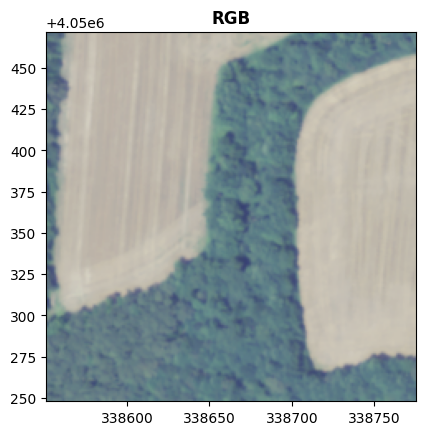

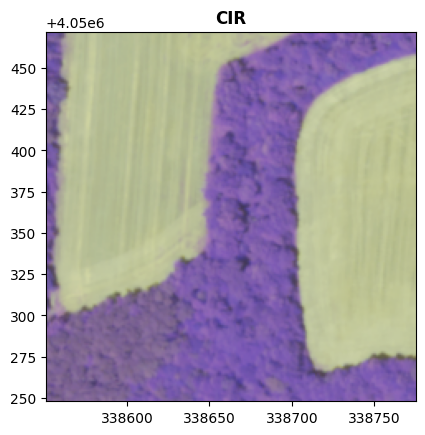

<Axes: title={'center': 'CIR'}>

In [39]:
import rasterio
import numpy as np
from rasterio.plot import show

src_file = './data/m_3607626_ne_18_1/input/00555.tif'
with rasterio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data (as numpy array)
    red_band = src.read(1) # only grab red band (as numpy array)
    
print('raster metadata:', meta)
print('raster shape:', data.shape)
print('red band raster shape:', red_band.shape)

data_rgb = data[:3]
show(data_rgb, transform=meta['transform'], vmin=0, vmax=255, title='RGB')
data_cir = data[[1, 0, 3], :, :] # grab only the G R NIR bands
show(data_cir, transform=meta['transform'], vmin=0, vmax=255, title='CIR')

### Housecleaning - Data Augmentation using Image Transformations

Before we write the code used for loading data to 

### Creating a Dataset class

In order to load data to train a neural network model in PyTorch, we need to create a custom class that tells PyTorch *how* to load each sample into memory, and what transformations need to be performed on each sample. If you're unfamiliar with this practice, you may not immediately see the value in it compared to simply using a list of samples or `numpy` arrays. Indeed, it may seem like more unnecessary boiler-plate code, but there are several important reasons why creating a custom `Dataset` class has its advantages:

1. It gives us near complete control on how data is loaded and passed to the model. For small, simple datasets it often more than enough to use a `numpy` array to load samples for training. However, when working with large, complicated datasets, we often need to load samples directly from the disk on the fly and modify them to be suitable for training. Using the `__getitem__` method, we can pass in an index and load 

2. - Using the `Dataset` class allows us to unlock the powerful features of object-oriented programming. We can store important information about the dataset - such as the distribution of classes, means, standard deviations, metadata, and more and access them easily, from both within the `Dataset` class definition and the object itself. As such, your dataset can have all sorts of useful properties outside of just the data. In the following example, we can have the `__getitem__` method of our `Dataset` class return the metadata of the sample - allowing us to easily save rasters with geospatial information on-the-fly during inference.

In [ ]:
from torch.utils.data import Dataset

# our custom NAIP_Dataset class will inherit from the Dataset class
class NAIP_Dataset(Dataset):
    
    def __init__(self, files: list[tuple[str, str]], mode: str='train'):
        self.file_path_list = files
        self.mode = mode # defines whether we are in training or validation mode
        
    def __len__(self):
        return len(self.files)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    # In our case, we will return a tuple of the form (X, y, meta), whera meta
    # is the metadata associated with the raster file.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index]
        
        X = rasterio.open(file_path[0]).read()
        y = rasterio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        # image transformations (more on this later)

In [ ]:
import torch.nn



#### Image Transforms (Rotate and Flip)

When training a deep learning model for image tasks, it is a good idea to use data augmentation in the form of image transforms during training. 

In [54]:
import torchvision
resnet = torchvision.models.resnet50(weights=False)

import segmentation_models_pytorch as smp

smp



/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class UNetDecoderBlock(nn.Module):
    
    def __init__(self,
        upsample_kernel_size: int=2,
        upsample_kernel_stride: int=2,
        conv_kernel_size: int=3,
        conv_kernel_stride: int=1,
    ):
        self.upsample_kernel_size = upsample_kernel_size
        self.upsample_kernel_stride = upsample_kernel_stride
        self.conv_kernel_size = conv_kernel_size
        self.conv_kernel_stride = conv_kernel_stride
        pass
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = nn.ConvTranspose2d(
            in_channels=x.shape[1],
            out_channels=x.shape[1] // 2,
            kernel_size=self.upsample_kernel_size,
            stride=self.upsample_kernel_stride,
        )
        

class UNetDecoder(nn.Module):
    
    def __init__(self,
        n_classes: int,
        output_size: int | tuple[int, int]=(256, 256),
        latent_dims: int=2048,
    ) -> None:
        
        pass
    
    def forward(self, x: torch.Tensor, encoder_features: torch.Tensor) -> torch.Tensor:
        
        # reverse encoder features (deep -> shallow)
        encoder_features = encoder_features[::-1]
        
        x = nn.MaxUnpool2d()

class UNet(nn.Module):
    
    def __init__(self, 
        n_classes: int,
        input_size: int | tuple[int, int]=(256, 256),
        n_channels: int=4, # NOTE: we are using 4 channels (RGB + NIR). Typically, n_channels=3 (RGB)
        resnet: torchvision.models.resnet.Ressnet=torchvision.models.resnet18(weights=True),
    ) -> None:
        
        self.encoder = resnet
        self.encoder.layers = [
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4,
        ]
        self.decoder = 
        